In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')

import numpy as np
import math
import matplotlib.pyplot as plt
import os
import time

from math import prod
import cv2

from ghost.multisim import GhostSimulator, GhostAnalyser

plt.rcParams['text.usetex'] = True

Simulation using: SLM resolution (24, 24), camera resolution (6, 6)
Reconstructed Image


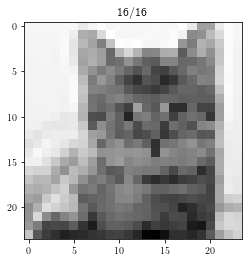

PSNR: inf


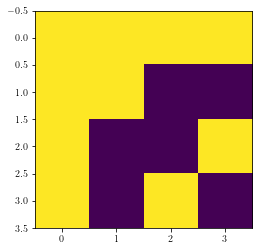

Original image:


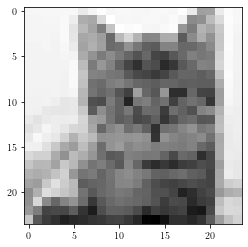

155.98611111111111 155.98611111111111
Active area of the camera


AttributeError: 'NoneType' object has no attribute 'sum'

In [20]:
# path = '../common/RC_780.png'
# slm_res = (128, 128)
# camera_res = (32, 32)
# mac_res = (4, 4)
# n = 16

path = '../common/cat.png'
slm_res = (24, 24)
camera_res = (6, 6)
mac_res = (4, 4)
rot = (0, 0)
n = 16
sigma = 0

sim = GhostSimulator(path, slm_res, camera_res, mac_res, n, rot=rot, sigma=sigma, method='zigzag')
cnt = sim.run_simulation()

print(f"Simulation using: SLM resolution {slm_res}, camera resolution {camera_res}")

print("Reconstructed Image")
plt.title(f"{n}/{prod(mac_res)}")
plt.imshow(np.abs(sim.G2), vmax=sim.G2.flatten().max(), cmap='gray')
plt.show()
# rmse = sim.calc_rmse()
# print('RMSE:', rmse)
psnr = sim.calc_psnr()
print('PSNR:', psnr)

plt.imshow(sim.h)
plt.show()

print("Original image:")
plt.imshow(sim.T, vmax=sim.G2.flatten().max(), cmap='gray')
plt.show()

print(np.average(sim.T), np.average(sim.G2))

print("Active area of the camera")
plt.imshow(sim.At.sum(axis=0).reshape(sim.shape_slm), cmap='gray')
plt.show()

print("Cali matrix sum (should be uniform)")
plt.imshow(sim.A.sum(axis=1).reshape(sim.shape_slm), cmap='gray')
plt.show()
print(f"average: {np.average(sim.A.sum(axis=1))}, min: {np.min(sim.A.sum(axis=1))}, max: {np.max(sim.A.sum(axis=1))}")

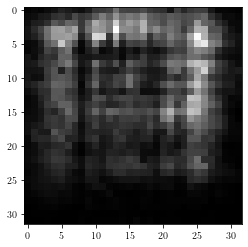

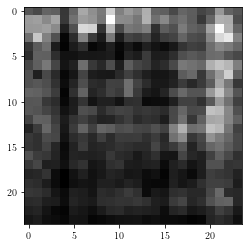

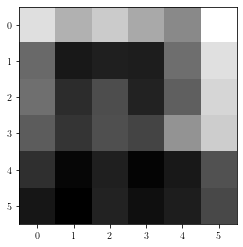

Simulation using: SLM resolution (24, 24), camera resolution (6, 6)
Reconstructed Image


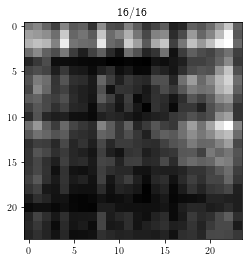

0 0
Reconstructed Image


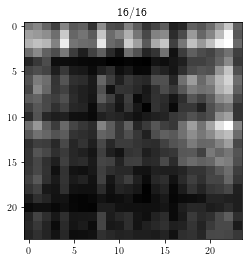

1 0
Reconstructed Image


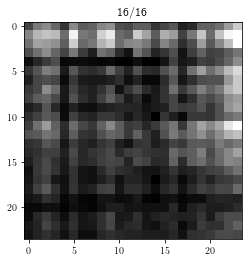

2 0
Reconstructed Image


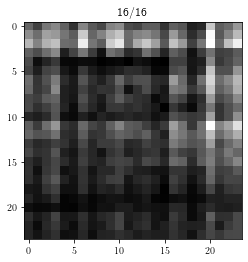

3 0
Reconstructed Image


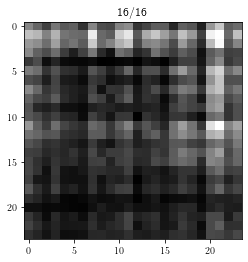

0 1
Reconstructed Image


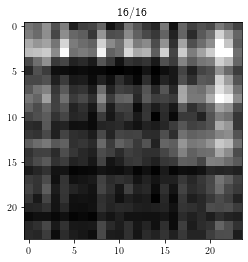

1 1
Reconstructed Image


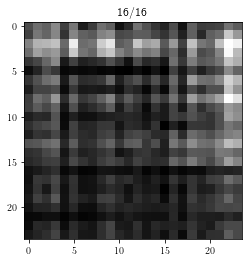

2 1
Reconstructed Image


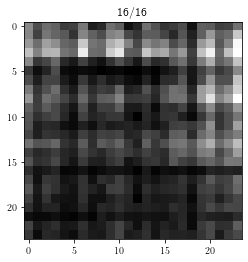

3 1
Reconstructed Image


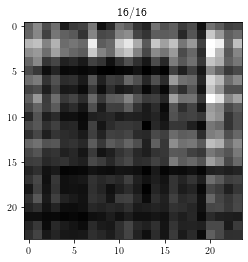

0 2
Reconstructed Image


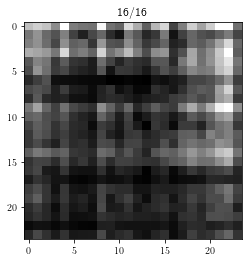

1 2
Reconstructed Image


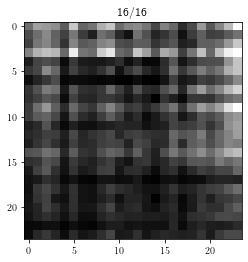

2 2
Reconstructed Image


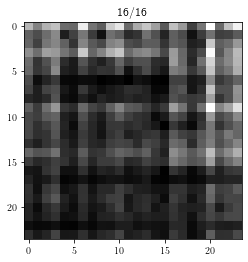

3 2
Reconstructed Image


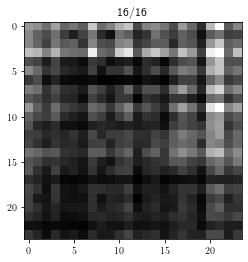

0 3
Reconstructed Image


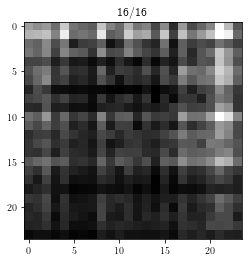

1 3
Reconstructed Image


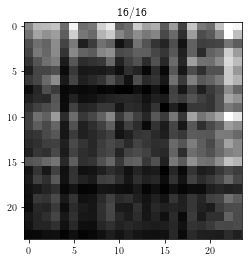

2 3
Reconstructed Image


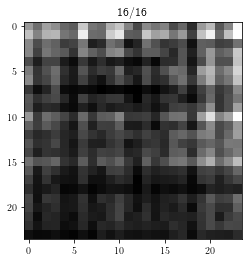

3 3
Reconstructed Image


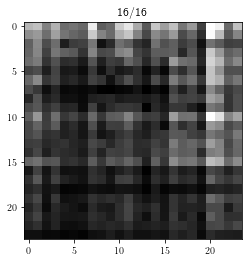

In [319]:
path = "/mnt/e/Data/JensenLab/220120 Multipixel Imaging 1/"
slm_res = (24, 24)
camera_res = (6, 6)
mac_res = (4, 4)
crop = (2, 2+24, 4, 4+24)
rot = (0, 0)
n = 16
sigma = 0

Ik_p = np.loadtxt(path + f'0p.csv', delimiter=',')
Ik_m = np.loadtxt(path + f'0m.csv', delimiter=',')
Ik = Ik_p - Ik_m
plt.imshow(Ik, cmap='gray')
plt.show()

Ik = Ik[crop[0]:crop[1], crop[2]:crop[3]]
plt.imshow(Ik, cmap='gray')
plt.show()

Ik = cv2.resize(Ik, (6, 6), interpolation=cv2.INTER_AREA)
plt.imshow(Ik, cmap='gray')
plt.show()


sim = GhostAnalyser(path, slm_res, camera_res, mac_res, crop, n, sigma, method='zigzag')
cnt = sim.run_analysis()

print(f"Simulation using: SLM resolution {slm_res}, camera resolution {camera_res}")

print("Reconstructed Image")
plt.title(f"{n}/{prod(mac_res)}")
plt.imshow(np.abs(sim.G2), vmax=sim.G2.flatten().max(), cmap='gray')
plt.show()

for y in range(4):
    for x in range(4):
        sim = GhostAnalyser(path, slm_res, camera_res, mac_res, crop, n, rot=(y, x), sigma=sigma, method='zigzag')
        cnt = sim.run_analysis()

        # print(f"Simulation using: SLM resolution {slm_res}, camera resolution {camera_res}")
        print(x, y)
        print("Reconstructed Image")
        plt.title(f"{n}/{prod(mac_res)}")
        plt.imshow(np.abs(sim.G2), vmax=sim.G2.flatten().max(), cmap='gray')
        plt.show()

# print("Active area of the camera")
# plt.imshow(sim.At.sum(axis=0).reshape(sim.shape_slm), cmap='gray')
# plt.show()

# print("Cali matrix sum (should be uniform)")
# plt.imshow(sim.A.sum(axis=1).reshape(sim.shape_slm), cmap='gray')
# plt.show()
# print(f"average: {np.average(sim.A.sum(axis=1))}, min: {np.min(sim.A.sum(axis=1))}, max: {np.max(sim.A.sum(axis=1))}")


generate hadamard matrix


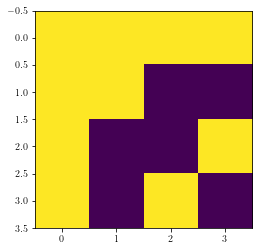

Generate some partial filter


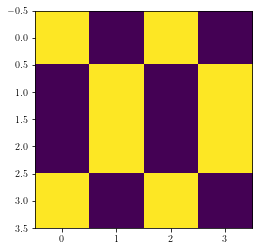

Generate some filter


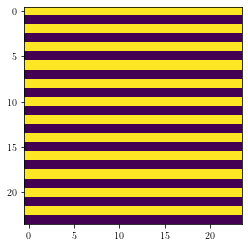

In [318]:
sim = GhostSimulator(path, slm_res, (24, 24), (4, 4),  64*64*0.1)
h = sim.generate_hadamard(sim.shape_mac)

print("generate hadamard matrix")
plt.imshow(sim.h)
plt.show()

print("Generate some partial filter")
hp = sim.generate_partial_filter(14)
plt.imshow(hp)
plt.show()

print("Generate some filter")
s = sim.generate_filter(3)
plt.imshow(s)
plt.show()

for i in range(16):
    s = sim.generate_filter(i)
    s_plus = s == 1
    s_minus = s == -1
    np.savetxt(f"../data/filter/filter_{i}+.txt", s_plus, fmt='%i')
    np.savetxt(f"../data/filter/filter_{i}-.txt", s_minus, fmt='%i')


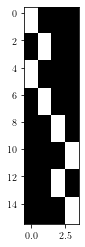

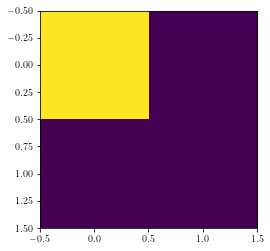

In [161]:
# ideal algo using cv2 resize

camera_res = (2, 2)
slm_res = (4, 4)

A = np.zeros((prod(slm_res), prod(camera_res)))

for i in range(slm_res[0]):
    for j in range(slm_res[1]):
        slm = np.zeros(slm_res)
        slm[i, j] = 1
        cam = cv2.resize(slm, camera_res, interpolation=cv2.INTER_AREA)
        cam = cam * prod(slm_res) / prod(camera_res)
        A[i*slm_res[1] + j, :] = cam.flatten()

plt.imshow(A, cmap='gray')
plt.show()

plt.imshow(A[5].reshape(camera_res))
plt.show()

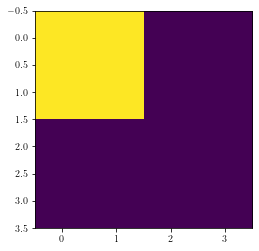

In [39]:
# simulate ideal algo

cam_res = (2, 2)
slm_res = (4, 4)

B = np.zeros(cam_res, dtype=np.ndarray)
for i in range(cam_res[0]):
    for j in range(cam_res[1]):
        B[i, j] = np.zeros(slm_res)
        for u in range(slm_res[0]):
            for v in range(slm_res[1]):
                if u >= i*slm_res[0]/cam_res[0] and u < (i+1)*slm_res[0]/cam_res[0] and v >= j*slm_res[1]/cam_res[1] and v < (j+1)*slm_res[1]/cam_res[1]:
                    B[i, j][u, v] = 1

plt.imshow(B[0,0])
plt.show()


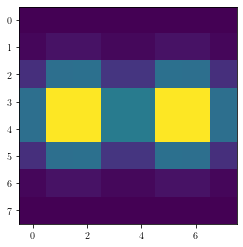

In [242]:
# optimizing gaussian simulation

cam_res = (2, 1)
slm_res = (8, 8)

sigma = 1

mac_res = slm_res[0]/cam_res[0], slm_res[1]/cam_res[1]

At = np.zeros((prod(cam_res), prod(slm_res)))
for i in range(prod(cam_res)):
        u, v = i // cam_res[1], i % cam_res[1]
        x = np.arange(0, slm_res[0], 1)
        y = np.arange(0, slm_res[1], 1)
        xv, yv = np.meshgrid(x, y)
        xy = (xv - (u+0.5)*mac_res[0]+0.5)**2 + (yv - (v+0.5)*mac_res[1]+0.5)**2
        temp = 1/(2*np.pi*sigma**2)*np.exp(-xy/(2*sigma**2))
        At[i] = temp.flatten()

S = At.T.sum(axis=1, keepdims=True)
A = At.T/S

# plt.imshow(At[0].reshape(slm_res))
# plt.show()

plt.imshow(At.sum(axis=0).reshape(slm_res))
plt.show()

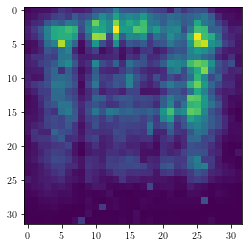

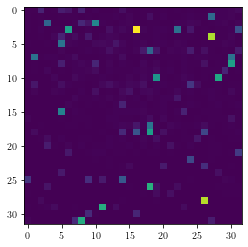

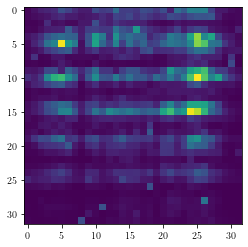

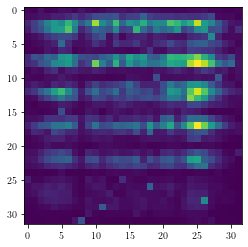

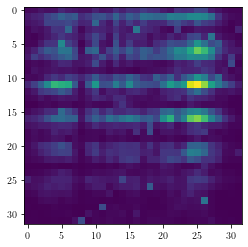

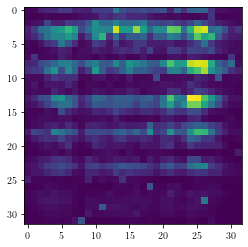

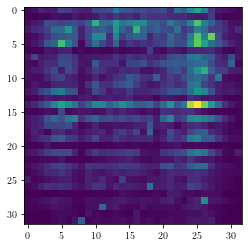

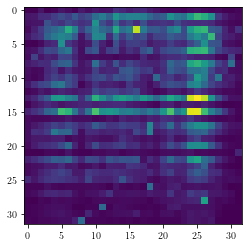

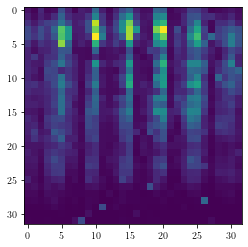

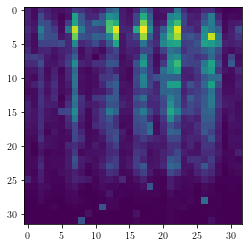

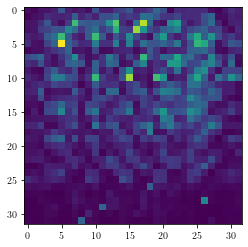

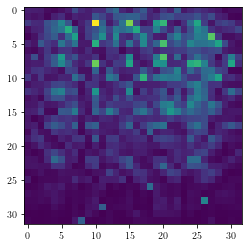

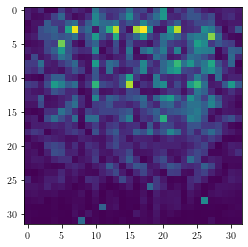

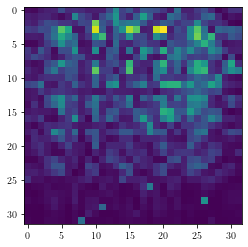

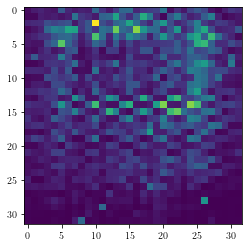

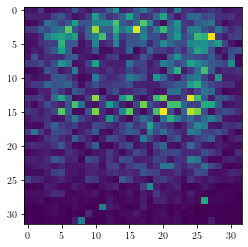

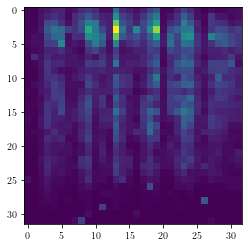

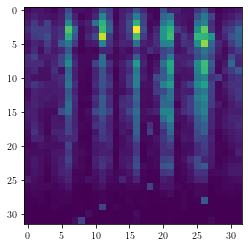

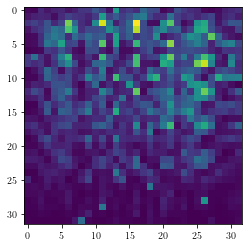

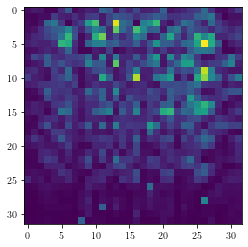

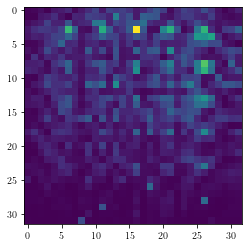

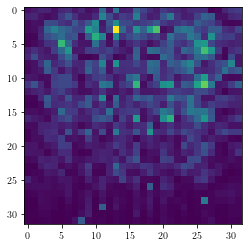

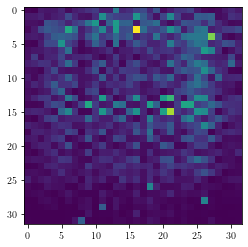

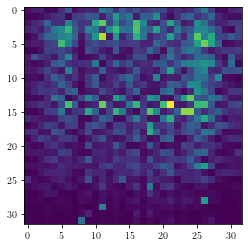

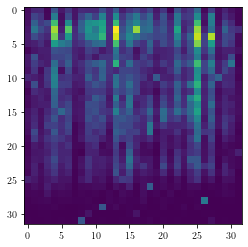

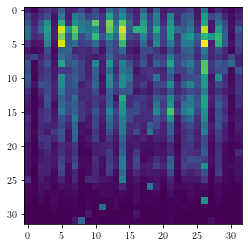

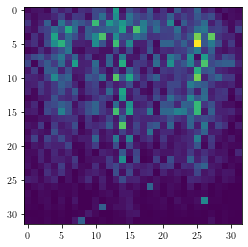

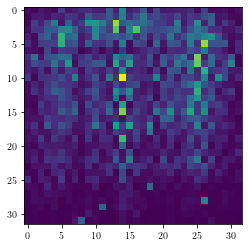

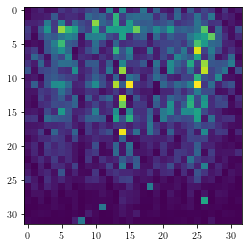

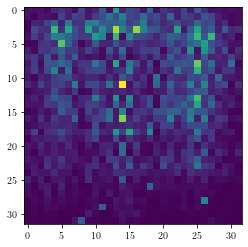

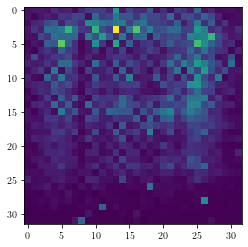

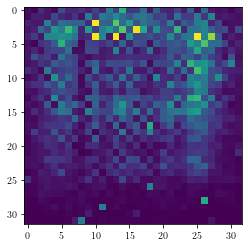

In [308]:
path = ("/mnt/e/Data/JensenLab/220120 Multipixel Imaging 1/")

i = 0

for i in range(16):
    Ik_p = np.loadtxt(path + f'{i}p.csv', delimiter=',')
    Ik_m = np.loadtxt(path + f'{i}m.csv', delimiter=',')
    Ik = Ik_p - Ik_m
    Ik = Ik[crop[0]:crop[1], crop[2]:crop[3]]
    Ik = cv2.resize(Ik, (6, 6), interpolation=cv2.INTER_AREA)

    # plt.imshow(Ik, cmap='gray')
    # plt.show()

    plt.imshow(Ik_p)
    plt.show()
    plt.imshow(Ik_m)
    plt.show()